In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import logging
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
import re

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# List of URLs for different cities and car brands
urls = {
    'Mumbai': 'https://www.cars24.com/buy-used-car?f=make%3A%3D%3Amahindra&sort=P&serveWarrantyCount=true&gaId=435619914.1722658140&storeCityId=2378',
    'Pune': 'https://www.cars24.com/buy-used-car?f=make%3A%3D%3Amahindra&sort=bestmatch&serveWarrantyCount=true&gaId=263356569.1722775375&storeCityId=2423',
    'Hyderabad':'https://www.cars24.com/buy-used-car?f=make%3A%3D%3Amahindra&sort=P&serveWarrantyCount=true&gaId=263356569.1722775375&storeCityId=3686' ,
    'Chennai': 'https://www.cars24.com/buy-used-car?f=make%3A%3D%3Amahindra&sort=bestmatch&serveWarrantyCount=true&gaId=263356569.1722775375&storeCityId=5732'
}

# HTML class definitions for scraping
main_div = '_2ujGx'
sub_div = '_2YB7p'
subsub_div = {
    'name': '_11dVb',
    'price': '_3RL-I',
    'emi': '_2O0yU',
    'details_list': '_3J2G-',
    'features': '_3JoYA'
}

# Data lists
name, price, emi, distance, fuel_type, transmission, features, city = [], [], [], [], [], [], [], []

def scrape_city(city_name, url):
    logging.info(f"Scraping data for {city_name}...")

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError for bad responses

        soup = BeautifulSoup(response.content, 'html.parser')
        logging.info(f"Page source length for {city_name}: {len(response.text)}")

        found_data = False

        for x in soup.find_all('div', {'class': main_div}):
            for i in x.find_all('div', {'class': sub_div}):
                found_data = True
                try:
                    car_name = i.find('h3', {'class': subsub_div['name']}).text
                    name.append(car_name.split()[2])  # Extract only the car model name
                except Exception as e:
                    logging.error(f"Error extracting name: {e}")
                    name.append(np.nan)
                try:
                    car_price = i.find('strong', {'class': subsub_div['price']}).text
                    price.append(car_price)
                except Exception as e:
                    logging.error(f"Error extracting price: {e}")
                    price.append(np.nan)
                try:
                    car_emi = i.find('span', {'class': subsub_div['emi']}).text
                    emi.append(car_emi)
                except Exception as e:
                    logging.error(f"Error extracting EMI: {e}")
                    emi.append(np.nan)
                try:
                    details_list = i.find('ul', {'class': subsub_div['details_list']})
                    car_distance = details_list.find_all('li')[0].text
                    car_fuel_type = details_list.find_all('li')[2].text
                    car_transmission = details_list.find_all('li')[4].text
                    distance.append(car_distance)
                    fuel_type.append(car_fuel_type)
                    transmission.append(car_transmission)
                except Exception as e:
                    logging.error(f"Error extracting distance, fuel type, or transmission: {e}")
                    distance.append(np.nan)
                    fuel_type.append(np.nan)
                    transmission.append(np.nan)
                try:
                    car_features = i.find('span', {'class': subsub_div['features']}).text
                    features.append(car_features)
                except Exception as e:
                    logging.error(f"Error extracting features: {e}")
                    features.append(np.nan)
                city.append(city_name)

        if not found_data:
            logging.warning(f"No data found for {city_name}")

    except requests.exceptions.HTTPError as http_err:
        logging.error(f"HTTP error occurred for {city_name}: {http_err}")
    except Exception as err:
        logging.error(f"An error occurred for {city_name}: {err}")

for city_name, url in urls.items():
    scrape_city(city_name, url)

# Create DataFrame
df = pd.DataFrame({
    "Brand": "Mahindra",  # Fixed brand name
    "Car Name": name,
    'Price': price,
    "EMI": emi,
    "Distance Driven": distance,
    "Fuel Type": fuel_type,
    "Transmission": transmission,
    "Features": features,
    "Location": city
})

# Save DataFrame to CSV
df.to_csv("Cars24_Mahindra.csv", index=False)

# Download the CSV file
#files.download('Cars24_Mahindra.csv')




Cleaned DataFrame:
      Brand Car Name  Price_Lakh  Emi_From Distance Driven Fuel Type  \
0  Mahindra   XUV500    0.000079   15503.0       66,595 km    Diesel   
1  Mahindra     Thar    0.000145   27580.0       11,951 km    Petrol   
2  Mahindra     Thar    0.000140   26705.0       10,637 km    Petrol   
3  Mahindra   XUV500    0.000069   15349.0       40,435 km    Diesel   
4  Mahindra   XUV500    0.000097   18558.0       67,404 km    Diesel   

  Transmission       Features Location  
0    Automatic  Reg. serviced   Mumbai  
1    Automatic      Top Model   Mumbai  
2    Automatic   Alloy wheels   Mumbai  
3       Manual  Spl. reg. no.   Mumbai  
4       Manual  Reg. serviced   Mumbai  

Basic Statistics:
       Price_Lakh      Emi_From
count   77.000000     77.000000
mean     0.000109  20948.103896
std      0.000038   7032.015986
min      0.000041   7967.000000
25%      0.000088  16911.000000
50%      0.000103  19548.000000
75%      0.000125  23907.000000
max      0.000258  49013.00

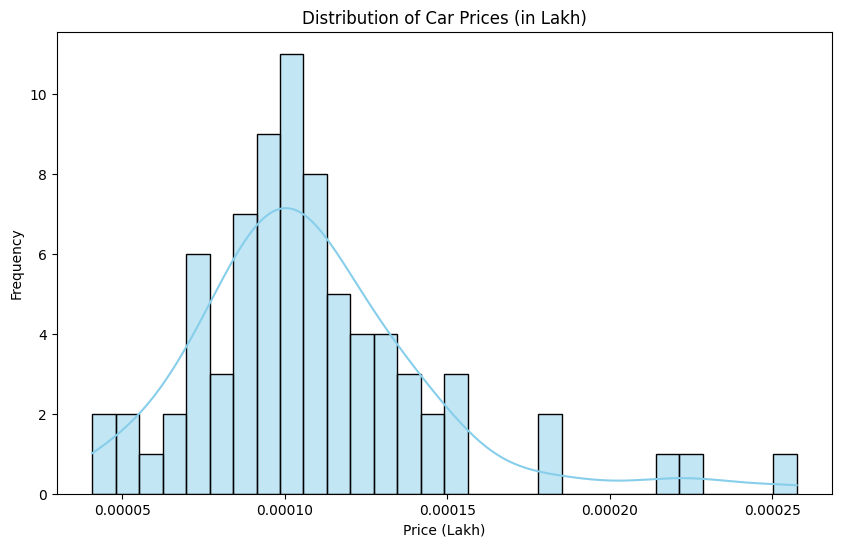

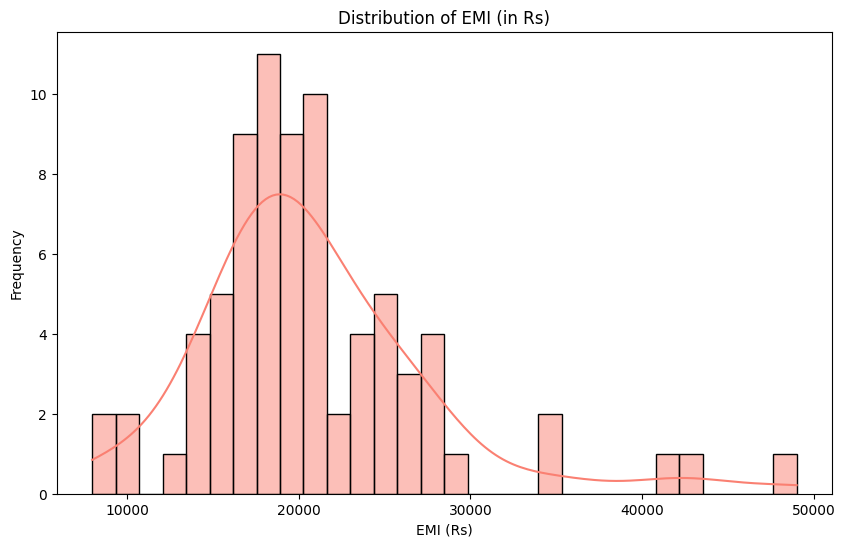

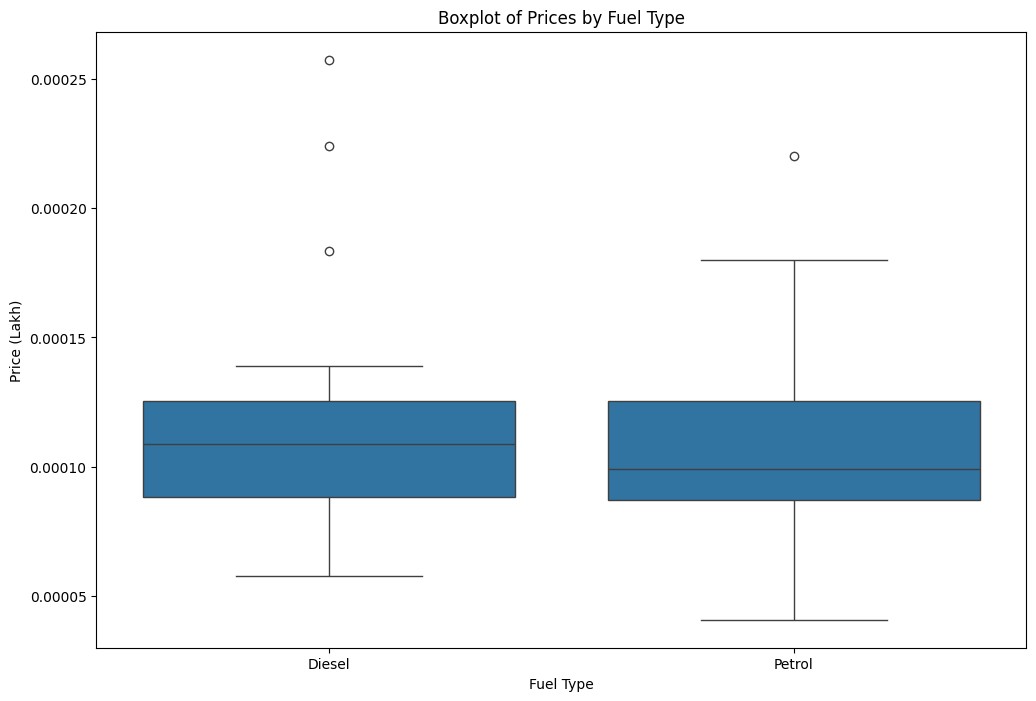

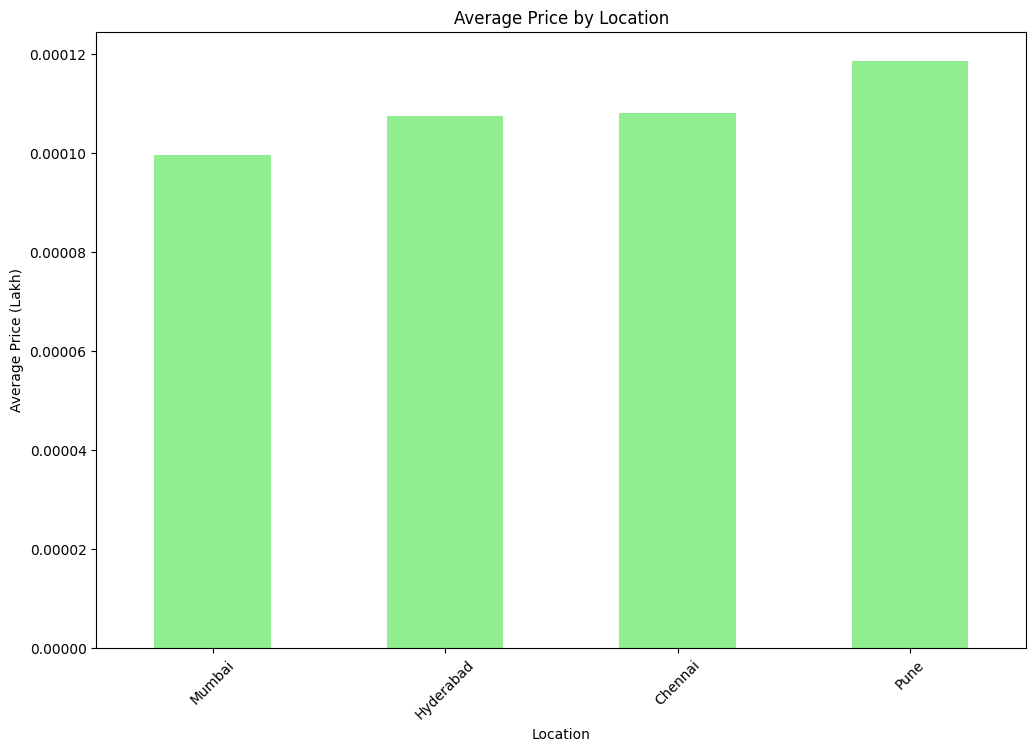

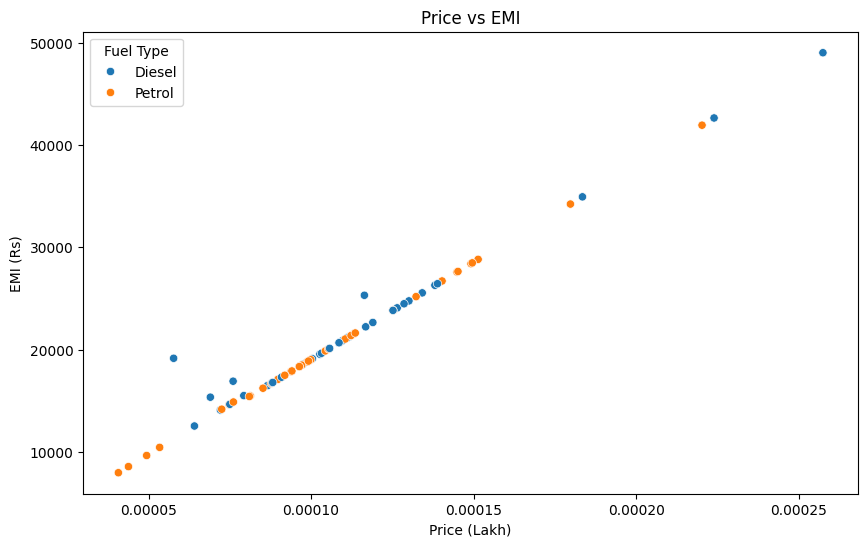

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data cleaning and analysis complete. Cleaned data saved to 'Cleaned_Cars24_Mahindra.csv'.


In [10]:


# Load the CSV data
#df = pd.read_csv("Cars24_Mahindra.csv")

# Rename columns
df.rename(columns={'Price': 'Price_Lakh', 'EMI': 'Emi_From'}, inplace=True)

# Clean 'Price_Lakh' column: Extract digits and convert to float
df['Price_Lakh'] = df['Price_Lakh'].apply(lambda x: float(re.sub(r'[^\d.]', '', x))/100000 if pd.notnull(x) else np.nan)

# Clean 'Emi_From' column: Extract digits and convert to float
df['Emi_From'] = df['Emi_From'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)) if pd.notnull(x) else np.nan)

# Remove any rows with NaN values in critical columns
df.dropna(subset=['Price_Lakh', 'Emi_From'], inplace=True)

# Show cleaned data
print("Cleaned DataFrame:")
print(df.head())

# Data analysis and visualization

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

# Distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price_Lakh'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Car Prices (in Lakh)')
plt.xlabel('Price (Lakh)')
plt.ylabel('Frequency')
plt.show()

# Distribution of EMI
plt.figure(figsize=(10, 6))
sns.histplot(df['Emi_From'], bins=30, kde=True, color='salmon')
plt.title('Distribution of EMI (in Rs)')
plt.xlabel('EMI (Rs)')
plt.ylabel('Frequency')
plt.show()

# Boxplot of prices by fuel type
plt.figure(figsize=(12, 8))
sns.boxplot(x='Fuel Type', y='Price_Lakh', data=df)
plt.title('Boxplot of Prices by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price (Lakh)')
plt.show()

# Average price by location
avg_price_by_location = df.groupby('Location')['Price_Lakh'].mean().sort_values()

plt.figure(figsize=(12, 8))
avg_price_by_location.plot(kind='bar', color='lightgreen')
plt.title('Average Price by Location')
plt.xlabel('Location')
plt.ylabel('Average Price (Lakh)')
plt.xticks(rotation=45)
plt.show()

# Relationship between Price and EMI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price_Lakh', y='Emi_From', data=df, hue='Fuel Type')
plt.title('Price vs EMI')
plt.xlabel('Price (Lakh)')
plt.ylabel('EMI (Rs)')
plt.show()

# Save cleaned data to a new CSV
df.to_csv("Cleaned_Cars24_Mahindra.csv", index=False)
# Download the CSV file
files.download("Cleaned_Cars24_Mahindra.csv")
# Notify completion
print("Data cleaning and analysis complete. Cleaned data saved to 'Cleaned_Cars24_Mahindra.csv'.")
